In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd
import cupy as cp

from tomo_encoders.tasks.digital_zoom import *
from tomo_encoders import viewer
sys.path.append('/home/atekawade/TomoEncoders/scratchpad/voids_paper/bin/tests')
from utils import *
import numexpr as ne
from tomo_encoders.misc.img_stats import calc_SNR

In [2]:
def make_binary_structure(radius):
    struct_size = 2*radius + 1
    struct = cp.ones(tuple([struct_size]*3), dtype = cp.uint8)

    r = cp.arange(-radius, radius + 1)

    zz, yy, xx = cp.meshgrid(r, r, r, indexing = 'ij')
    dist = cp.sqrt(zz**2 + yy**2 + xx**2)
    struct[dist > radius] = 0
    return struct

In [3]:
projs, theta, center = read_raw_data(raw_fname, wd*b)
b, b_K = 4, 4
print(f"EXPERIMENT with b, b_K {(b,b_K)}")

EXPERIMENT with b, b_K (4, 4)


In [4]:
def downsample(data, b):
    """Downsample data"""
    binning = int(np.log2(b))
    for j in range(binning):
        x = data[:, :, ::2]
        y = data[:, :, 1::2]
        data = ne.evaluate('0.5*(x + y)')  # should use multithreading
        
    for k in range(binning):
        x = data[:, ::2]
        y = data[:, 1::2]
        data = ne.evaluate('0.5*(x + y)')
    return data.astype(np.uint16)

In [5]:
def coarse_map_func(projs, theta, center, strategy):

    print(f"STRATEGY: {strategy}")
    t_gpu = TimerGPU("secs")
    memory_pool = cp.cuda.MemoryPool()
    cp.cuda.set_allocator(memory_pool.malloc)
    
    t_gpu.tic()
    if "binning" in strategy:
        raw_data = downsample(projs[::b_K], b), theta[::b_K,...], center/b
    elif "striding" in strategy:
        raw_data = projs[::b_K,::b,::b], theta[::b_K,...], center/b
    t_gpu.toc("DOWNSAMPLING")
    t_gpu.tic()
    # fbp
    _, nz, n = raw_data[0].shape    
    V = cp.empty((nz,n,n), dtype = cp.float32)
    recon_all_gpu(*raw_data, V)
#     V_rec = V.get()
    if "gaussian" in strategy:
        V[:] = ndimage.gaussian_filter(V,0.5)
    
    # binarize
    voxel_values = get_values_cyl_mask(V[::2,::2,::2], 1.0).get()
    rec_min_max = modified_autocontrast(voxel_values, s=0.01)
    thresh = cp.float32(threshold_otsu(voxel_values))    
    V[:] = (V<thresh).astype(cp.uint8)        
    
    if "median" in strategy:
        V[:] = ndimage.median_filter(V, 3)  
        
    if "closing" in strategy:
        V[:] = ndimage.binary_closing(V, structure = make_binary_structure(1))
    
    t_rec = t_gpu.toc('RECONSTRUCTION')
#     V_seg = V.get()
    
#     print(f"\tSTAT: signal-to-noise {calc_SNR(V_rec, V_seg)}")
    
    # connected components labeling
    t_gpu.tic()
    V = cp.array(V, dtype = cp.uint32)
    V[:], n_det = ndimage.label(V,structure = cp.ones((3,3,3),dtype=cp.uint8))    
    voids_b = Voids().count_voids(V.get(), b)    
    t_label = t_gpu.toc('LABELING')

    voids_b["rec_min_max"] = rec_min_max
    voids_b.compute_time = {"reconstruction" : t_rec, "labeling" : t_label}

    del V
    cp.fft.config.clear_plan_cache(); memory_pool.free_all_blocks()            
    return voids_b

In [6]:
strategies = [\
              "binning", \
#               "binning median", \
#               "binning gaussian", \
#               "striding", \
#               "striding median", \
              "striding gaussian", \
#               "striding median gaussian"\
              "striding gaussian closing",\
              "binning closing",\
              "striding closing"\
             ]
size_dict = {}
voids_dict = {}

for strategy in strategies:
    voids_dict[strategy] = coarse_map_func(projs, theta, center, strategy)
    size_dict[strategy] = np.cbrt(voids_dict[strategy]["sizes"])

STRATEGY: binning
	TIME: DOWNSAMPLING 7.86 secs
	TIME: RECONSTRUCTION 9.15 secs
	STAT: voids found - 359093
	TIME: LABELING 10.00 secs
STRATEGY: striding gaussian
	TIME: DOWNSAMPLING 0.00 secs
	TIME: RECONSTRUCTION 9.05 secs
	STAT: voids found - 372264
	TIME: LABELING 10.06 secs
STRATEGY: striding gaussian closing
	TIME: DOWNSAMPLING 0.00 secs
	TIME: RECONSTRUCTION 9.23 secs
	STAT: voids found - 355181
	TIME: LABELING 10.57 secs
STRATEGY: binning closing
	TIME: DOWNSAMPLING 6.19 secs
	TIME: RECONSTRUCTION 8.73 secs
	STAT: voids found - 344833
	TIME: LABELING 10.08 secs
STRATEGY: striding closing
	TIME: DOWNSAMPLING 0.00 secs
	TIME: RECONSTRUCTION 9.35 secs
	STAT: voids found - 2351628
	TIME: LABELING 31.92 secs


In [7]:
def print_stats(size_arr, desc):
    msg = []
    msg.append(f"\n{desc}: {size_arr.size};")
    i = 1; msg.append(f"> {i} pixels: {np.sum(size_arr>i)};")
    msg.append(f"perc of 1 pixel voids: {np.sum(size_dict[desc] == 1)/np.size(size_dict[desc]):.2f}")
    print("".join(msg))
    return
for strategy in strategies:
    print_stats(size_dict[strategy], strategy)


binning: 359093;> 1 pixels: 226090;perc of 1 pixel voids: 0.37

striding gaussian: 372264;> 1 pixels: 218656;perc of 1 pixel voids: 0.41

striding gaussian closing: 355181;> 1 pixels: 208403;perc of 1 pixel voids: 0.41

binning closing: 344833;> 1 pixels: 217044;perc of 1 pixel voids: 0.37

striding closing: 2351628;> 1 pixels: 608838;perc of 1 pixel voids: 0.74


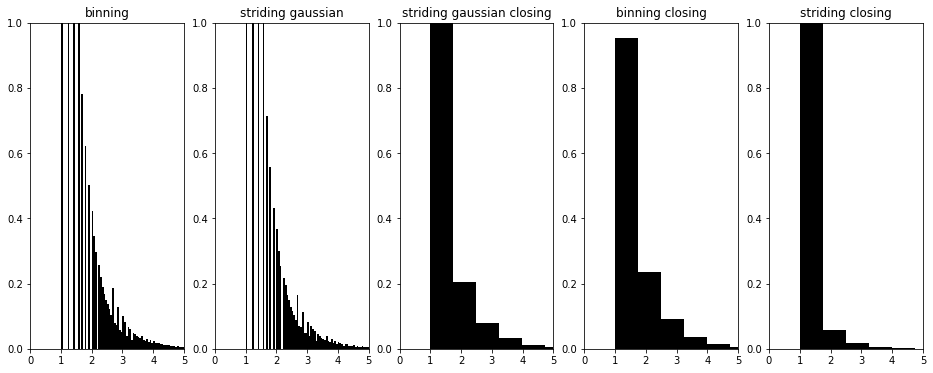

In [17]:
fig, ax = plt.subplots(1,len(strategies), figsize = (16,6))
# colors = ["red", "blue", "green", "black"]
for i, strategy in enumerate(strategies):
    h = ax[i].hist(size_dict[strategy], color = "black", bins = 1000, density = True)
    ax[i].set_xlim([0,5])
    ax[i].set_ylim([0,1])
    ax[i].set_title(strategy)

In [9]:
def print_stats(size_arr, desc):
    pix = 2
    cond_list = np.all(np.clip((voids_dict[strategy]["cents"]-voids_dict[strategy]["cpts"])*2-pix,0,None), axis = 1)        
    
    msg = f"STRATEGY: {desc:25s}: {np.sum(cond_list)/np.size(cond_list):.4f}; {np.sum(cond_list):5g}; {np.size(cond_list):5g}"
    
    print(msg)
    return
print("fraction of voids above pixel size threshold")
idx_strat = np.argsort([len(size_dict[strategy]) for strategy in strategies])
for ids in idx_strat:
    strategy = strategies[ids]
    print_stats(size_dict[strategy], strategy)

fraction of voids above pixel size threshold
STRATEGY: binning closing          : 0.0590; 20351; 344833
STRATEGY: striding gaussian closing: 0.0522; 18533; 355181
STRATEGY: binning                  : 0.0579; 20801; 359093
STRATEGY: striding gaussian        : 0.0512; 19047; 372264
STRATEGY: striding closing         : 0.0162; 38081; 2.35163e+06


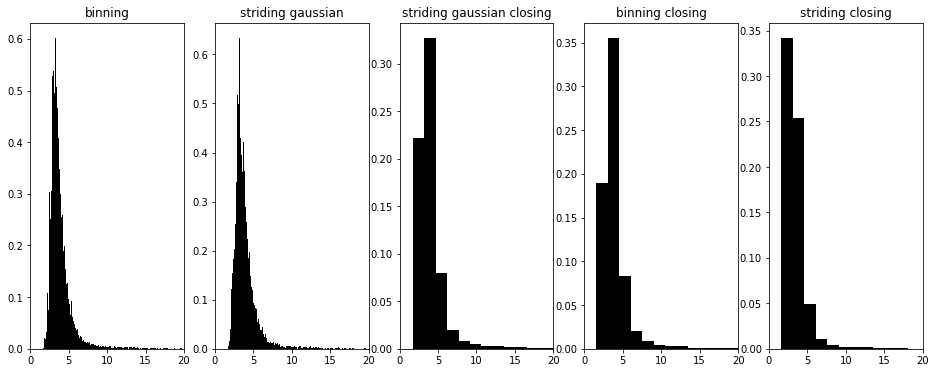

In [10]:
fig, ax = plt.subplots(1,len(strategies), figsize = (16,6))
# colors = ["red", "blue", "green", "black"]
for i, strategy in enumerate(strategies):
    pix = 2
    cond_list = np.all(np.clip((voids_dict[strategy]["cents"]-voids_dict[strategy]["cpts"])*2-pix,0,None), axis = 1)        
    h = ax[i].hist(size_dict[strategy][cond_list], color = "black", bins = 500, density = True)
    ax[i].set_xlim([0,20])
    ax[i].set_title(strategy)